<a href="https://colab.research.google.com/github/Spandan-Madan/in_distribution_adversarial_examples/blob/main/demos/demo_imagenet_cma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Spandan-Madan/in_distribution_adversarial_examples
!pip install tensorflow-addons
!pip install pyheif
ROOT='/content/in_distribution_adversarial_examples'
MPI_ROOT='/content/in_distribution_adversarial_examples/single_view_mpi'
!wget https://storage.googleapis.com/stereo-magnification-public-files/models/single_view_mpi_full_keras.tar.gz -O "/content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/single_view_mpi_full_keras.tar.gz"
!tar -xzvf /content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/single_view_mpi_full_keras.tar.gz -C "/content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/"

import sys
sys.path.append(ROOT)
sys.path.append(MPI_ROOT)

fatal: destination path 'in_distribution_adversarial_examples' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-02-25 19:14:39--  https://storage.googleapis.com/stereo-magnification-public-files/models/single_view_mpi_full_keras.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161684857 (154M) [application/x-gzip]
Saving to: ‘/content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/single_view_mpi_full_keras.tar.gz’

/content/in_distrib 100%[===================>] 154.19M  23.6MB/s    in 7.7s    

2023-02-25 19:14:48 (20.1 MB/s) - ‘/content/in_distribu

In [2]:
from tensorflow_addons import image as tfa_image
import numpy as np
import tensorflow as tf

In [3]:
import tensorflow as tf

from single_view_mpi.libs import mpi
from single_view_mpi.libs import nets

In [4]:
input = tf.keras.Input(shape=(None, None, 3))
output = nets.mpi_from_image(input)

model = tf.keras.Model(inputs=input, outputs=output)
print('Model created.')
model.load_weights('/content/in_distribution_adversarial_examples/single_view_mpi/single_view_mpi/single_view_mpi_full_keras/single_view_mpi_keras_weights')
print('Weights loaded.')


Model created.
Weights loaded.


In [5]:
import torch
import torchvision
from torchvision import models
from PIL import Image
import pyheif
import os
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from torchvision import transforms

In [6]:
image_url = 'https://animalia-bio.us-east-1.linodeobjects.com/animals/photos/full/1.25x1/smooth-green-snake-liochlorophis-vernalis-1.webp'
response = requests.get(image_url)
im = Image.open(BytesIO(response.content))

In [7]:
temp_im = im
temp_im = temp_im.resize((512, 512))
temp_im.save('/content/temp_image.png')

In [8]:
inputfile = '/content/temp_image.png'
input_rgb = tf.image.decode_image(tf.io.read_file(inputfile), dtype=tf.float32)
layers = model(input_rgb[tf.newaxis])[0]
depths = mpi.make_depths(1.0, 100.0, 32).numpy()

In [9]:
reference_pose = tf.constant(
    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
intrinsics = tf.constant([1.0, 1.0 * 16/9, 0.5, 0.5])

def render(xoffset, yoffset, zoffset):
  # The translation is the final column of the pose matrix
    target_pose = tf.constant(
    [[1.0, 0.0, 0.0, -xoffset],
     [0.0, 1.0, 0.0, -yoffset],
     [0.0, 0.0, 1.0, -zoffset]])
    image = mpi.render(layers, depths,
                     reference_pose, intrinsics,  # Reference view
                     target_pose, intrinsics,  # Target view
                     height=512, width=512)
    return image

In [10]:
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),  
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

# with open('.imagenet_classes.txtf
imagenet_model = models.resnet18(pretrained=True)
imagenet_model.eval();

def predict_from_rendered(rendered, show = True, return_val = False):
    rendered_img = Image.fromarray((np.array(rendered)*255).astype('uint8'))

    img_t = transform(rendered_img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = imagenet_model(batch_t)

    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    pred_idx = indices[0][:1].item()
    title = "Class:%s, Confidence:%0.02f"%(pred_idx, percentage[pred_idx].item()/100)

    if show:
        rendered_resized = rendered_img.resize((256, 256))
        center_cropped = rendered_resized.crop((16,16,240,240))
        plt.imshow(center_cropped)
        plt.title(title)
        plt.axis('off')
        plt.show()
    if return_val:
        return pred_idx, percentage[pred_idx].item()/100

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def objective(offsets, show = False):
    rendered_img = render(offsets[0], offsets[1], offsets[2])
    pred_id, percent = predict_from_rendered(rendered_img, False, True)
    if show == True:
        plt.imshow(rendered_img)
        plt.title('Pred:%s'%pred_id)
        plt.axis('off')
    return percent, pred_id

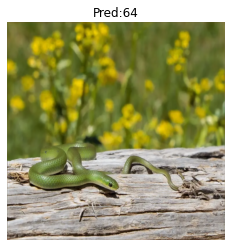

In [12]:
gt_prob, gt_cat = objective(np.array([0,0,0]), True)

In [13]:
import cma 
start_pos = np.array([0.0,0.0,0.0])
es = cma.CMAEvolutionStrategy(start_pos, 0.005)

es.optimize(objective, verb_disp = True, iterations=5, correct_prediction = gt_cat)

Adversarial found, should stop now.
Predictions are :[64, 46, 64, 64, 64, 64, 64]
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 3.261640167236328e-01 1.0e+00 4.28e-03  4e-03  4e-03 0:02.0
Adversarial found, trying to stop.
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 3.261640167236328e-01 1.0e+00 4.28e-03  4e-03  4e-03 0:02.0
termination by {}
best f-value = 0.3261640167236328
solution = [ 0.00150909 -0.00207397 -0.00080962]


In [14]:
errored_indexes = [i for i in range(len(es.predictions)) if es.predictions[i] != gt_cat]

In [15]:
errored_settings = [es.prediction_settings[i] for i in errored_indexes][0]

In [16]:
rendered = render(errored_settings[0],  errored_settings[1],  errored_settings[2])
adversarial_image = Image.fromarray((np.array(rendered)*255).astype('uint8'))

original_rendered = render(0,0,0)
original_image = Image.fromarray((np.array(original_rendered)*255).astype('uint8'))

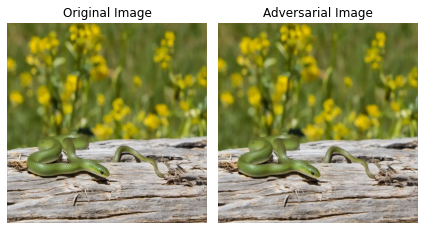

In [17]:
plt.figure(figsize=(6,12))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(adversarial_image)
plt.title('Adversarial Image')
plt.axis('off')
plt.tight_layout()
plt.show()